### Enrichments using gseapy package DEGs

In [ ]:
import pandas as pd
import gseapy as gp
import os 
import matplotlib.pyplot as plt

In [2]:
gp.__version__

'1.1.8'

In [2]:
FAP_ligands = ['LAMB1', 'LAMC2', 'TGFBI', 'SEMA4D' ,'AGRN', 'SEMA5A','SEMA3F', 'INHBA', 'LAMA5', 'COL7A1']

FAP_targets = ['SOX9' ,'CCND1' ,'MET', 'ID1' , 'PTMA',  'CLU' , 'TGIF1', 'EDN1' , 'GDF15']

In [ ]:
def multi_enrichr_analysis(gene_list, gene_sets=None, organism='Human', cutoff=0.05):
    """
    Run Enrichr analysis on a list of genes across multiple gene sets and return combined results.

    Parameters:
        gene_list (list): List of gene symbols (e.g., ['TP53', 'EGFR']).
        gene_sets (list): List of Enrichr gene set names to query.
        organism (str): Organism, default is 'Human'.
        cutoff (float): Adjusted p-value threshold for filtering.

    Returns:
        pd.DataFrame: Combined enrichment results.
    """

    if gene_sets is None:
        # Default drug + disease-related sets
        gene_sets = [
            'MSigDB_Hallmark_2020',
            'DGIdb_Drug_Targets_2024',
        ]
    
    combined_results = []

    for gs in gene_sets:
        try:
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gs,
                organism=organism,
                outdir=None,  # Prevent file output
            )
            df = enr.results
            if not df.empty:
                df['Gene_set'] = gs
                df = df[df['Adjusted P-value'] < cutoff]
                combined_results.append(df)
        except Exception as e:
            print(f"Failed on {gs}: {e}")

    if combined_results:
        return pd.concat(combined_results, ignore_index=True)
    else:
        print("No significant enrichments found.")
        return pd.DataFrame()

In [4]:
import os 

path = 'C:/Users/jondor/Documents/DT/Pathway_enrichment/'
if not os.path.exists(path):
    os.makedirs(path)

os.chdir(path)

print(os.getcwd())

C:\Users\jondor\Documents\DT\Pathway_enrichment


In [ ]:
pathway_gene_sets = [
    'MSigDB_Hallmark_2020'
]

In [ ]:
def filter_enrich_save(df, gene_sets, organism='Human', cutoff=0.05):
    """
    Filter the dataframe for specific ligands and targets, then run enrichment analysis.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing ligand-receptor interactions.
        ligand_list: List of ligands to filter.
        targets (list): List of target genes to filter.
        gene_sets (list): List of gene sets for enrichment analysis.
        organism (str): Organism for enrichment analysis.
        cutoff (float): Adjusted p-value threshold for filtering.

    Returns:
        pd.DataFrame: Summary of enrichment results.
    """
    df_name = getattr(df, 'name', 'unknown')
    ## rename column to target
    if 'target' not in df.columns and 'gene' in df.columns:
        df = df.rename(columns={'gene': 'target'})

    res = multi_enrichr_analysis(df['target'].unique().tolist(), gene_sets=gene_sets, organism=organism, cutoff=cutoff)
    summary_genes = res[res['Adjusted P-value'] < cutoff][['Gene_set', 'Term', 'Odds Ratio', 'P-value', 'Adjusted P-value', 'Genes']]
    summary_genes = summary_genes.sort_values(by='Adjusted P-value')
    for drug_gene_set in gene_sets:
        # combine filename with os.getcwd() to ensure the file is saved in the current working directory
        current_dir = os.getcwd()
        filename = os.path.join(current_dir, f'{df_name}_{pathway_gene_sets}_pathway_enrichment.csv')
        summary_genes[summary_genes['Gene_set'] == pathway_gene_sets].to_csv(filename, index=False)
        print(f"Saved pathway enrichment results for {df_name} on {pathway_gene_sets} to {filename}")

In [ ]:
## DEGs from FAP polyps
FAP_polyps_DEGs = pd.read_csv('C:/Users/jondor/Documents/DT/FAP/DE_output_contrastlist_2.csv')
FAP_polyps_DEGs = FAP_polyps_DEGs[
    (FAP_polyps_DEGs['p_adj'] < 0.05) & 
    ((FAP_polyps_DEGs['logFC'] > 1) | (FAP_polyps_DEGs['logFC'] < -1))
]

FAP_polyps_DEGs.name  = 'FAP_polyps_DEGs'

filter_enrich_save(FAP_polyps_DEGs, pathway_gene_sets, organism='Human', cutoff=0.05)
# filter for epithelial cells
FAP_polyps_DEGs_Epithelial = FAP_polyps_DEGs[FAP_polyps_DEGs['cluster_id'] == 'Epithelial']
FAP_polyps_DEGs_Epithelial.name = 'FAP_polyps_Epithelial_DEGs'

filter_enrich_save(FAP_polyps_DEGs_Epithelial, pathway_gene_sets, organism='Human', cutoff=0.05)

In [ ]:
## DEGs from sporadic CRC

sCRC_DEGs = pd.read_csv('C:/Users/jondor/Documents/DT/Sporadic_CRC/DE_output_contrastlist_1.csv')
# filter adjusted p-value < 0.05 and log2FoldChange > 1 and log2FoldChange < -1
sCRC_DEGs = sCRC_DEGs[(sCRC_DEGs['p_adj'] < 0.05) & 
                                   (sCRC_DEGs['logFC'] > 1) | 
                                   (sCRC_DEGs['logFC'] < -1)]
sCRC_DEGs.name = 'sCRC_DEGs'
filter_enrich_save(sCRC_DEGs, pathway_gene_sets, organism='Human', cutoff=0.05)

#filter for epithelial cells
sCRC_DEGs_Epi = sCRC_DEGs[sCRC_DEGs['cluster_id'] == 'Epithelial']
sCRC_DEGs_Epi.name = 'sCRC_Epithelial_DEGs'
filter_enrich_save(sCRC_DEGs_Epi, pathway_gene_sets, organism='Human', cutoff=0.05)

In [ ]:
# for Bulk data, we can use the same approach as above

# read excel file with row headers
import datetime

bulk_degs = pd.read_excel("C:/Users/jondor/Downloads/Druliner_2018_SciR_Bulk_data.xlsx",header=1)
bulk_degs = bulk_degs[bulk_degs['PValue'] < 0.05]
bulk_degs = bulk_degs[(bulk_degs['logFC'] > 1) | (bulk_degs['logFC'] < -1)]
bulk_degs_clean = bulk_degs[~bulk_degs['GeneName'].apply(lambda x: isinstance(x, datetime.datetime))]
bulk_degs_clean = bulk_degs_clean.rename(columns={'GeneName': 'target'})
bulk_degs_clean.name = 'Bulk_DEGs'

filter_enrich_save(bulk_degs_clean, pathway_gene_sets, organism='Human', cutoff=0.05)

In [ ]:

res = multi_enrichr_analysis(bulk_degs_clean['target'].unique().tolist(), gene_sets=pathway_gene_sets, organism='Human', cutoff=0.05)
summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
summary_genes = summary_genes.sort_values(by='Adjusted P-value')
for drug_gene_set in pathway_gene_sets:
    # combine filename with os.getcwd() to ensure the file is saved in the current working directory
    import os
    current_dir = os.getcwd()
    filename = os.path.join(current_dir, f'bulk_data_DEG_{drug_gene_set}_enrichment.csv')
    summary_genes[summary_genes['Gene_set']==drug_gene_set].to_csv(filename, index=False)
    print(f"Saved enrichment results for {drug_gene_set} to {filename}")

### On a second datasets DE genes

In [7]:
## read files 

import os

dir_path = "C:/Users/jondor/Documents/DT/Dataset2/"

files = [f for f in os.listdir(dir_path) if f.endswith('.tsv')]

## read files into a list of dataframes

dfs = {}
for file in files:
    if file.endswith(".tsv"):
        var_name = os.path.splitext(file)[0]
        file_path = os.path.join(dir_path, file)
        df = pd.read_csv(file_path, sep='\t')
        dfs[var_name] = df

 

In [ ]:
dfs.keys()

In [ ]:
for var_name, df in dfs.items():
    print(df.columns)


In [ ]:
for key, df in dfs.items():
    df = df[(df['adj.P.Val'] < 0.05) &  (df['logFC'] > 1) | (df['logFC'] < -1)].copy()
    ## check if Gene.symbol or Symbol column exists. If Symbol exists, rename it to Gene.symbol
    if 'Gene.symbol' not in df.columns and 'Symbol' in df.columns:
        df.rename(columns={'Symbol': 'Gene.symbol'}, inplace=True)
    ## check if 'Gene.symbol', 'adj.P.Val', and 'logFC' columns exist, otherwise skip loop iteration
    if not all(col in df.columns for col in ['Gene.symbol' ,'adj.P.Val', 'logFC']):
        print(f"Skipping {key} due to missing required columns.")
        continue
    df = df[['Gene.symbol', 'adj.P.Val', 'logFC']].dropna().copy()
    print(df.head())
    res = multi_enrichr_analysis(df['Gene.symbol'].unique().tolist(), gene_sets=pathway_gene_sets, organism='Human', cutoff=0.05)
    summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
    summary_genes = summary_genes.sort_values(by='Adjusted P-value')
    for drug_gene_set in pathway_gene_sets:
        # combine filename with os.getcwd() to ensure the file is saved in the current working directory
        import os
        current_dir = os.getcwd()
        # replace '.' with '_' in the key to create a valid filename
        key_ = key.replace('.', '_')
        filename = os.path.join(current_dir, f'{key_}_{drug_gene_set}_enrichment.csv')
        summary_genes[summary_genes['Gene_set']==drug_gene_set].sort_values(by='Adjusted P-value').to_csv(filename, index=False)
        print(f"Saved enrichment results for {key} against {drug_gene_set} to {filename}")

### Plotting pathways

In [ ]:
##  redeclaring 
pathway_gene_sets = [
    #'DGIdb_Drug_Targets_2024', 
    'MSigDB_Hallmark_2020' # only want pathways 
]

In [ ]:
## read files from folders 

import os
import pandas as pd

dir_path = os.getcwd()  # or specify your directory path

files = [f for f in os.listdir(dir_path) if f.endswith('.csv') and 'MSigDB_Hallmark_2020' in f]

## read files into a list of dataframes

dfs = {}
for file in files:
    if file.endswith(".csv"):
        var_name = os.path.splitext(file)[0]
        ## split the var_name by '_' and remove the last 5 parts
        var_name_parts = var_name.split('_')
        # custom logic based on length of var_name_parts
        if len(var_name_parts) > 6:
            var_name = '_'.join(var_name_parts[:-5])
        elif len(var_name_parts) <= 6 and len(var_name_parts) > 3:
            var_name = '_'.join(var_name_parts[:-4])
        print(f"var name: {var_name}")
        file_path = os.path.join(dir_path, file)
        df = pd.read_csv(file_path)
        df = df.sort_values(by='Odds Ratio', ascending=False)
        df['Stage'] = var_name
        dfs[var_name] = df

In [ ]:
print(dfs.keys())

In [16]:
# remove 'GSE40362_AdenomatouspolypsvsTumor', 'GSE128435_TumorvsNormal', 'GSE128435_PolypsvsNormal', 'FAP_Polyps_Epithelial_Targets', 'FAP_polyps_Targets' from dfs
keys_to_remove = [
    'Bulk_DEGs',
    'GSE40362_AdenomatouspolypsvsTumor', 
    'GSE128435_TumorvsNormal', 
    'GSE128435_PolypsvsNormal', 
    'FAP_list_Epithelial_Targets', 
    'FAP_list_Targets'
]

for key in keys_to_remove:
    if key in dfs:
        del dfs[key]

In [ ]:
print(f"Remaining keys: {dfs.keys()}")

In [ ]:
combined = pd.concat(dfs.values(), ignore_index=True)

wide_df = combined.pivot_table(index="Term", columns="Stage", values="Odds Ratio")

min_non_null = wide_df.count().min()
print(f"Minimum non-null values in any column: {min_non_null}")



# Sort the Dataframe by the column with the lowest numb er of non-null values
if min_non_null > 0:
    # Find the column with the least number of non-null values
    min_col = wide_df.count().idxmax()
    print(f"Column with the least non-null values: {min_col}")
    # Sort by that column
    wide_df = wide_df.sort_values(by=min_col, ascending=True)



## decide order of stages by number of na values

stage_order = ['FAP_polyps_DEGs', 'sCRC_DEGs', 'GSE41657_LGDvsNormal', 'GSE41657_HGDvsNormal','GSE41657_TumorvsNormal'] 

print(f"Stage order based on non-null counts: {stage_order}")

# only keep columns that are in stage_order
stage_order = [stage for stage in stage_order if stage in wide_df.columns]

# Reorder the DataFrame based on the stage order
wide_df = wide_df[stage_order]

In [45]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 7,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

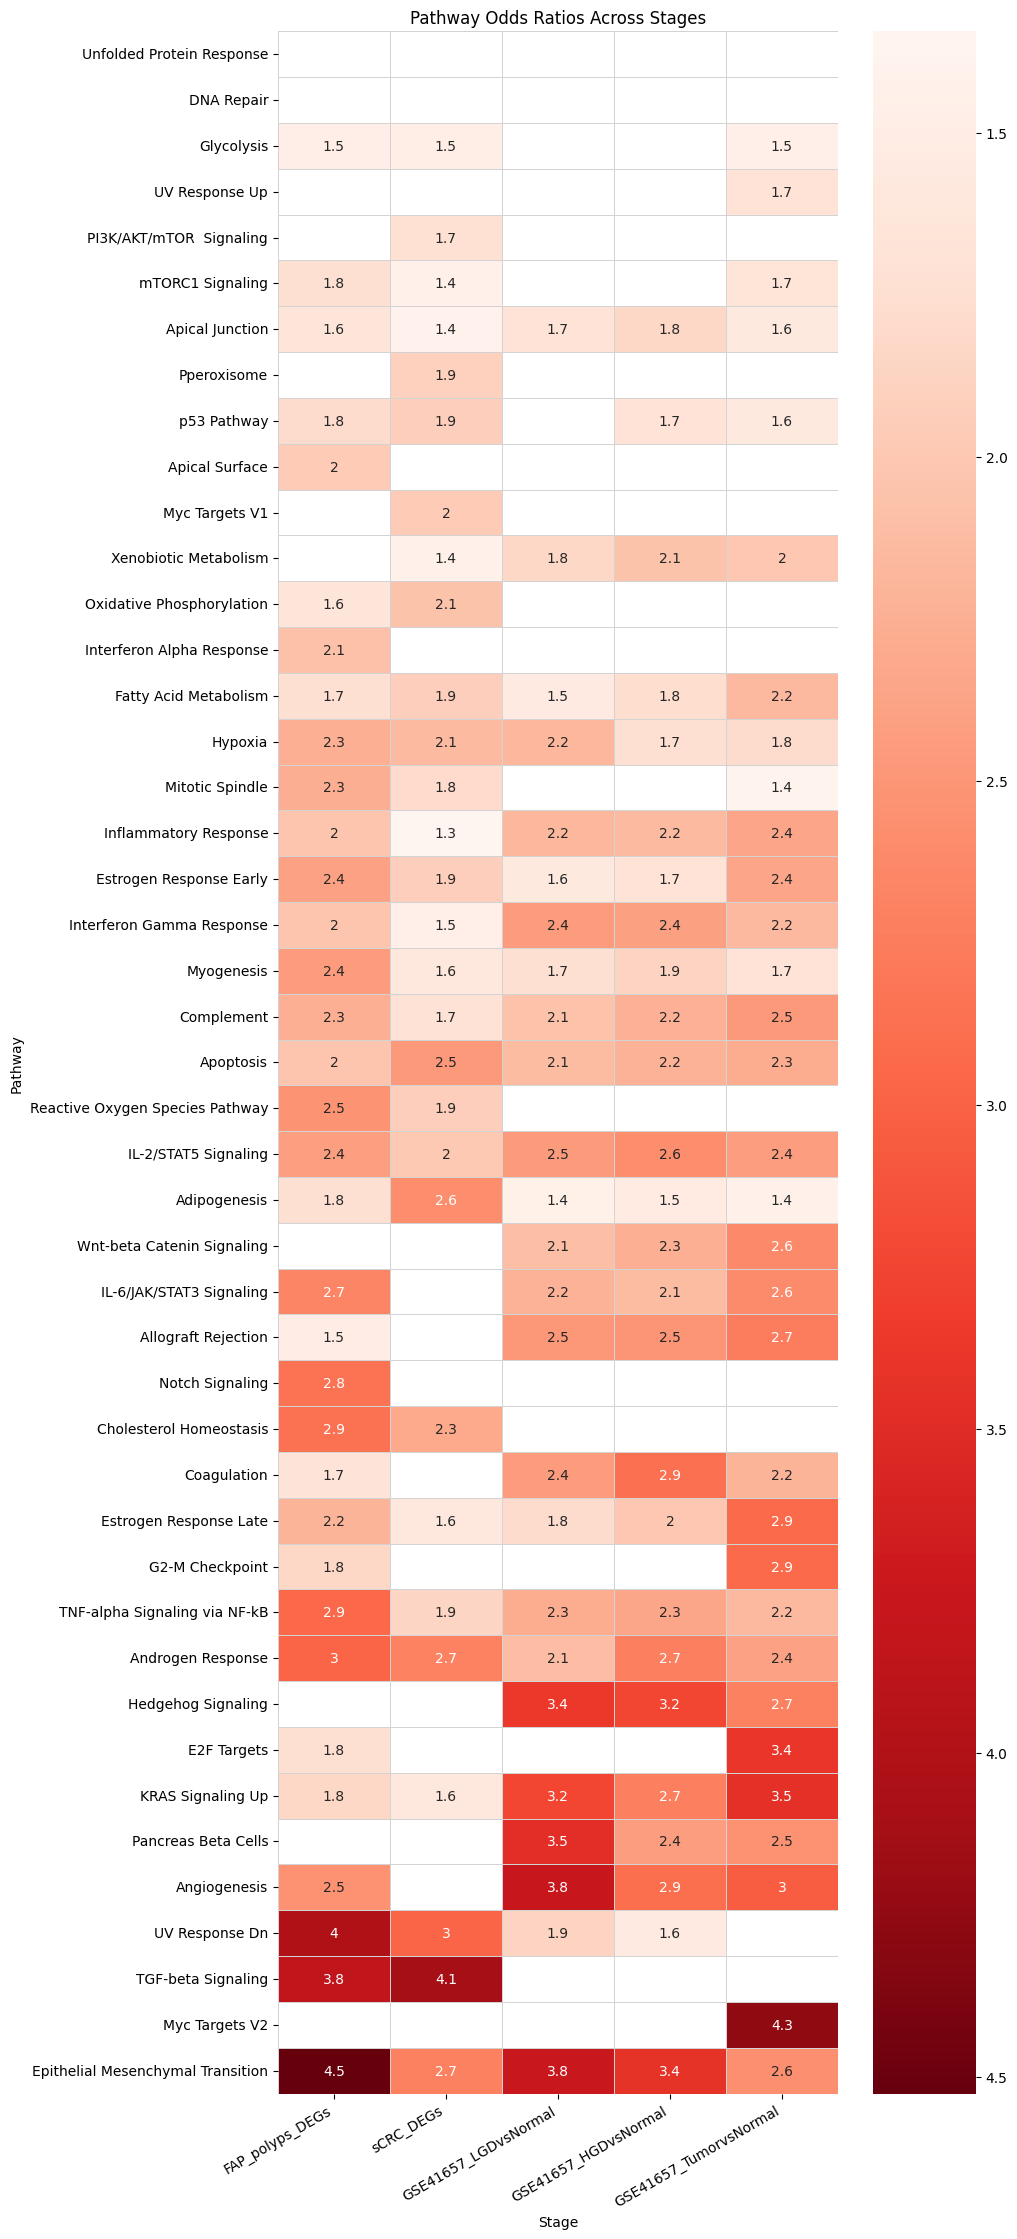

In [ ]:
# Fill NaN values with 0 for better visualization
wide_df = wide_df.fillna(-1)
wide_df = wide_df.loc[wide_df.max(axis=1).sort_values(ascending=True).index]

mask = wide_df == -1

# Create the plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, len(wide_df) * 0.5))  # dynamic height
## x axis labels to not be rotated

ax = sns.heatmap(wide_df,
                 mask=mask,  # mask out the NaNs 
                 annot=True, cmap="Reds", linewidths=0.7, linecolor='lightgray')

# Invert the colorbar axis so high is at bottom
cbar = ax.collections[0].colorbar
cbar.ax.invert_yaxis()

plt.xticks(rotation=30, ha='right')
plt.title("Pathway Odds Ratios Across Stages")
plt.xlabel("Stage")
plt.ylabel("Pathway")
plt.tight_layout()
plt.show()


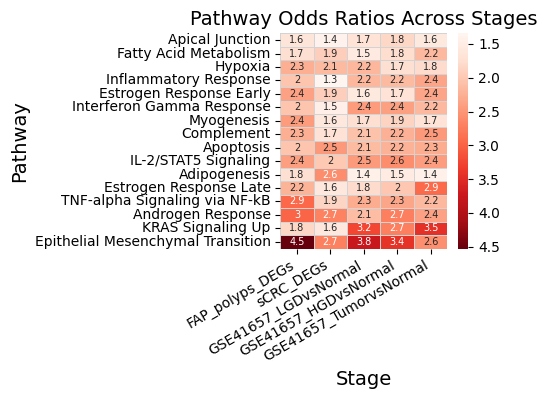

C:\Users\jondor\Documents\DT\Pathway_enrichment


In [ ]:
# Drop rows with even a single missing value
wide_df_no_nan = wide_df[(wide_df != -1).all(axis=1)]

# Optional: sort by max value as before
wide_df_no_nan = wide_df_no_nan.loc[wide_df_no_nan.max(axis=1).sort_values(ascending=True).index]

# Create the plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))  # dynamic height

ax = sns.heatmap(wide_df_no_nan,
                 annot=True, cmap="Reds", linewidths=0.7, linecolor='lightgray')

# Invert the colorbar axis so high is at bottom
cbar = ax.collections[0].colorbar
cbar.ax.invert_yaxis()

plt.xticks(rotation=30, ha='right')
plt.title("Pathway Odds Ratios Across Stages")
plt.xlabel("Stage")
plt.ylabel("Pathway")
plt.tight_layout()
plt.savefig("Pathway_Odds_Ratios_Across_Stages_no_NaN.pdf")
plt.show()
